In [1]:
import thermopyl as th
from thermopyl import thermoml_lib
import cirpy
import numpy as np
import pandas as pd
import itertools

import functools
from functools import reduce
from os.path import expanduser
from joblib import Memory

import matplotlib.pyplot as plt

import os
import re
from collections import defaultdict
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
def find_permutations(df, lst):
    # Generate all possible permutations of the strings in the list
    permutations = ['__'.join(comb) for comb in itertools.permutations(lst)]
    
    # Find all entries in the DataFrame where 'components' equals to any of the permutations
    print(f'Looking for mixtures: {permutations}')
    result = df[df['components'].isin(permutations)]
    
    return result

def strip_none_columns(df):
    return df.copy().dropna(axis=1, how='all').reset_index(drop=True)

def merge_dfs(df1, df2):
    # Rule 2 and 3
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df = df1.combine_first(df2)
    # return df
    # Rule 4
    for column in df1.columns:
        # if column in df2.columns:
        # print(df1.shape, df2.shape) 
        if column in df2.columns and (df1[column].to_numpy() != df2[column].to_numpy()).any() and (df1[column].notnull().any()) and (df2[column].notnull().any()):
            df[column + '_2'] = df2[column]
    return df

def merge_dataframe_folds(df, fold_number):
    # Function to apply the merging rules

    # Divide the dataframe into fold_number parts
    fold_size = len(df) // fold_number
    folds = [df.iloc[i * fold_size:(i + 1) * fold_size] for i in range(fold_number)]

    # Merge the folds gradually
    merged_df = folds[0].copy()
    for i in range(1, fold_number):
        merged_df = merge_dfs(merged_df, folds[i].copy())

    return merged_df
    
def merge_groups(groups, df_split):
    df_groups = []
    for group in groups:
        merged_df = df_split[group[0]]
        for df_num in group[1:]:
            merged_df = merge_dfs(merged_df, df_split[df_num])
        df_groups.append(merged_df)
    return df_groups

def combine_dfs(df_list):
    # combined_df = df_list[0]
    # for df in df_list[1:]:
    #     combined_df = pd.concat([df1, df2], ignore_index=True, sort=False)
    combined_df = pd.concat(df_list, ignore_index=True, sort=False)
    return combined_df

def find_none_transitions(df):
    # Initialize an empty list to store the indices
    transition_indices = []

    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Skip the column if it has no None values
        if not df[column].isna().any():
            continue

        # Get the indices where the value changes from None to not-None or vice versa
        transitions = df[column].isna().ne(df[column].shift().isna())

        # Add the indices to the list
        transition_indices.extend(transitions[transitions].index.tolist())

    # Remove duplicates and sort the indices
    sorted_indices = sorted(set(transition_indices))

    return sorted_indices


def split_dataset_by_None(df):
    # Initialize an empty list to store the split DataFrames
    dfs = []
    
    # Initialize start index
    start_idx = 0
    # Loop through the DataFrame using 'iterrows()'
    for idx, row in df.iterrows():
        # Check if there's a change from None to not None or vice versa in any column
        if (row.isnull() != df.iloc[idx - 1].isnull()).any() and idx > 0:
            # If there's a change, slice the DataFrame from the start index to the current index
            # and append to the list
            dfs.append(df.iloc[start_idx:idx].reset_index(drop=True))
            # dfs[-1] = dfs[-1].reset_index(drop=True)
            # Update the start index to the current index
            start_idx = idx
    
    dfs.append(df.iloc[start_idx:])
    return dfs

def find_mergeable_datasets(df_list, pivotal_columns):
    # This dictionary will store the mergeable DataFrames indices as keys and the DataFrames as values
    mergeable_datasets = np.zeros((len(df_list), len(df_list)))

    # Iterate over the DataFrame list to compare each DataFrame with one another
    for i in range(len(df_list)):
        for j in range(i+1, len(df_list)):
            # Check if the DataFrames have the same size
            if df_list[i].shape == df_list[j].shape:
                # print("shape", i, j)
                # print(df_list[i][pivotal_columns], '\n', df_list[j][pivotal_columns])
                # Check if the DataFrames have the same values in the pivotal columns
                
                # print(df_list[i][pivotal_columns].reset_index(drop=True) == df_list[j][pivotal_columns].reset_index(drop=True))
                # if df_list[i][pivotal_columns].equals(df_list[j][pivotal_columns]):
                # print(df_list[i][pivotal_columns].equals(df_list[j][pivotal_columns]))
                # print((df_list[i][pivotal_columns].reset_index(drop=True) == df_list[j][pivotal_columns].reset_index(drop=True)).all())
                should_be_merged = True
                for pcol in pivotal_columns:
                    if pcol in df_list[i].columns:
                        # print(df_list[i][pcol] == df_list[j][pcol])
                        # is_col_eq = (df_list[i][pcol] == df_list[j][pcol]).all()
                        is_col_eq = df_list[i][pcol].equals(df_list[j][pcol])
                        should_be_merged |= is_col_eq
                    # print("shape", i, j)
                    # If they should be merged, add their indices and DataFrames to the dictionary
                    # mergeable_datasets.setdefault(i, []).append(j)
                if should_be_merged:
                    mergeable_datasets[i, j] = 1
                    mergeable_datasets[j, i] = 1

    # print(mergeable_datasets)
    groups = []
    set_group = np.zeros((len(df_list)))
    for i in range(len(df_list)):
        if set_group[i] > 0:
            continue
        n_group = len(groups)+1
        group_indices = [i] + [index for index, link in enumerate(mergeable_datasets[i]) if link == 1]
        set_group[group_indices] = n_group
        groups.append(group_indices)

    # Return the dictionary containing indices of mergeable DataFrames and the DataFrames themselves
    return groups

# Example usage:
# Assuming 'dataframes' is your list of DataFrames and 'pivotal_cols' is your list of pivotal column names
# mergeable_datasets = find_mergeable_datasets(dataframes, pivotal_cols)
# Now 'mergeable_datasets' will have the indices of DataFrames that should be merged as keys

def refine_datasets(df_filtered, filenames):
    refined_dfs = []
    for filename in filenames:
        df_test = strip_none_columns(df_filtered[df_filtered['filename'] == filename])
        # print(find_none_transitions(df_test))
        # df_merge_test = merge_dataframe_folds(df_test, 2)
        # df_merge_test
        # df_test
        df_split = split_dataset_by_None(df_test)
        # print([len(split) for split in df_split])
        groups = find_mergeable_datasets(df_split, ['Temperature, K', 'Pressure, kPa', 'Mole fraction'])
        print(f"Groups are: {groups}, dataframe sizes are: {[len(split) for split in df_split]}")
        refined_dfs.append(combine_dfs(merge_groups(groups, df_split)))
    return combine_dfs(refined_dfs)


In [3]:
def get_standart_df(refined_df):
    new_df = pd.DataFrame()
    
    # Copy 'filename' column
    new_df['filename'] = refined_df['filename'].copy()
    
    # Rename 'Temperature, K' to 'temperature'
    new_df['temperature'] = refined_df['Temperature, K']
    
    # Rename 'Mole fraction' to 'liquid_fraction'
    new_df['liquid_fraction'] = refined_df['Mole fraction']
    
    new_df['gas_fraction'] = refined_df.get('Mole fraction_2', None)
    new_df['density'] = refined_df.get('Mass density, kg/m3', None)
    new_df['viscosity'] = refined_df.get('Viscosity, Pa*s', None)
    
    
    # Merge ['Pressure, kPa', 'Vapor or sublimation pressure, kPa', 'Critical pressure, kPa'] into 'pressure'
    pressure_cols = ['Pressure, kPa', 'Vapor or sublimation pressure, kPa', 'Critical pressure, kPa']
    existing_pressure_cols = [col for col in pressure_cols if col in refined_df.columns]
    new_df['pressure'] = refined_df[existing_pressure_cols].apply(lambda row: row.dropna().iloc[0] if row.count() > 0 else np.nan, axis=1)
    return new_df


In [4]:
def get_mean_criticals(standart_df):
    temperatures = standart_df['temperature'].unique()
    temperatures = sorted([temp for temp in temperatures if not np.isnan(temp)])
    absml = 0.0
    absmg = 1.0
    mean_criticals = dict()
    for temp in temperatures:
        # Filter data for the current temperature
        temp_df = standart_df[standart_df['temperature'] == temp].sort_values('pressure')
    
        # Check if 'liquid_fraction' column exists and is not all NaN
        max_liquid = 0.0
        min_gas = 1.0
        if 'liquid_fraction' in temp_df.columns and not temp_df['liquid_fraction'].isna().all():
            max_liquid = temp_df['liquid_fraction'].loc[temp_df['liquid_fraction'].last_valid_index()]
    
        # Check if 'gas_fraction' column exists and is not all NaN
        if 'gas_fraction' in temp_df.columns and not temp_df['gas_fraction'].isna().all():
            min_gas = temp_df['gas_fraction'].loc[temp_df['gas_fraction'].last_valid_index()]
    
        absml = max(max_liquid, absml)
        absmg = min(min_gas, absmg)
        mean_critical = (max_liquid + min_gas)/2
        mean_criticals[temp] = mean_critical
        
    return mean_criticals
        
def plot_temps(standart_df, mean_criticals):
    # Get unique temperatures
    temperatures = standart_df['temperature'].unique()
    temperatures = sorted([temp for temp in temperatures if not np.isnan(temp)])
    
    for temp in temperatures:
        # Filter data for the current temperature
        temp_df = standart_df[standart_df['temperature'] == temp].sort_values('pressure')
    
        # Create a figure and axis
        fig, ax = plt.subplots()
    
        # Check if 'liquid_fraction' column exists and is not all NaN
        if 'liquid_fraction' in temp_df.columns and not temp_df['liquid_fraction'].isna().all():
            ax.plot(temp_df['liquid_fraction'], temp_df['pressure'], '-o', label='Liquid Fraction')
            
        # # Check if 'gas_fraction' column exists and is not all NaN
        if 'gas_fraction' in temp_df.columns and not temp_df['gas_fraction'].isna().all():
            ax.plot(temp_df['gas_fraction'], temp_df['pressure'], '-o', label='Gas Fraction')
            
        ax.axvline(x=mean_criticals[temp], color='purple', linestyle='--', label='Mean Critical')
    
        # Set labels and title
        ax.set_xlabel('Fraction')
        ax.set_ylabel('Pressure')
        ax.set_title(f'Pressure vs Fraction at Temperature {temp}K')
    
        # Show legend
        ax.legend()
    
        # Show the plot
        plt.show()


In [5]:
# Function to find all mixtures containing a specific component
def find_mixtures_with_component(df, component):
    components = df['components'].unique()

    # Split the mixtures into separate components
    components_split = pd.Series(components).str.split('__')
    
    # Flatten the list of lists and get unique components
    unique_components = set([item for sublist in components_split for item in sublist])
    
    # Convert to a sorted list if needed
    unique_components = sorted(unique_components)
    
    # print(len(unique_components))

    # return df[df['components'].apply(lambda x: component in x.split('_'))]
    return df[df['components'].apply(lambda x: component in x.split('__'))]['components'].unique()


In [6]:
def read_file(filename, temperature):
    with open(filename, 'r') as file:
        lines = file.readlines()[35:]  # Skip first 35 lines
    data = []

    for line in lines:
        elements = line.split('\t')  # Split line into elements by tabs
        if len(elements) >= 17:  # Check if there are at least 17 elements
            element_8 = elements[7]  # Get 8th element (0-indexed)
            element_10 = float(elements[9])/1000 # pressure
            element_12 = elements[11]  # gas_fraction
            element_17 = elements[16]  # liquid_fraction
            
            if element_8 != 'NaN':
                found_data = True
            if element_8 == 'NaN' and found_data:
                break           

            if element_8 != 'NaN':
                data.append([temperature, float(element_10), float(element_12), float(element_17)])
    # return data
    return pd.DataFrame(data, columns=['temperature', 'pressure', 'gas_fraction', 'liquid_fraction'])

def group_files_by_kij(directory):
    # Dictionary to hold lists of filenames grouped by kij
    grouped_files = defaultdict(list)
    
    # Regular expression to match filenames and extract kij
    pattern = re.compile(r'out_[^_]+_([^_]+)\.txt')
    
    # Iterate over all files in the specified directory
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            kij = match.group(1)
            grouped_files[kij].append(filename)
    
    return grouped_files

def get_mses(data_first, data_second, power=3):
    # Remove None values separately for gas_fraction and liquid_fraction
    data_first_gas = data_first.dropna(subset=['gas_fraction'])
    data_first_liquid = data_first.dropna(subset=['liquid_fraction'])
    
    data_second_gas = data_second.dropna(subset=['gas_fraction'])
    data_second_liquid = data_second.dropna(subset=['liquid_fraction'])
    
    # Function to fit polynomial and calculate MSE
    def fit_and_calculate_mse(data1, data2, column):
        if len(data1) < power + 1 or len(data2) < power + 1:
            return None
        poly1 = np.polyfit(data1['pressure'], data1[column], power)
        poly2 = np.polyfit(data2['pressure'], data2[column], power)
        poly1_func = np.poly1d(poly1)
        poly2_func = np.poly1d(poly2)
        pressure_common = np.linspace(min(data1['pressure'].min(), data2['pressure'].min()), 
                                      max(data1['pressure'].max(), data2['pressure'].max()), 100)
        values1 = poly1_func(pressure_common)
        values2 = poly2_func(pressure_common)
        return mean_squared_error(values1, values2)
    
    mse_gas = fit_and_calculate_mse(data_first_gas, data_second_gas, 'gas_fraction')
    mse_liquid = fit_and_calculate_mse(data_first_liquid, data_second_liquid, 'liquid_fraction')

    return mse_gas, mse_liquid

def calculate_mses(directory, real_data_filename):
    real_data = pd.read_csv(real_data_filename)
    grouped_files = group_files_by_kij(directory)
    mses = dict()
    for file in list(grouped_files.items())[0][1]:
        temperature = float(file.split('_')[1])
        mses[temperature] = dict()
    for kij, files in grouped_files.items():
        for file in files:
            temperature = float(file.split('_')[1])
            file_data = read_file(directory + file, temperature)
            cut_real_data = real_data[real_data['temperature'] == temperature]
            mses[temperature][float(kij)] = get_mses(file_data, cut_real_data, 2)
    return mses

def get_liquid_gas_mse_values(kij_dict):
    kijs = []
    mse_values = []
    for kij, mse in sorted(kij_dict.items()):
        if mse is not None:
            kijs.append(kij)
            mse_values.append(mse)
    values_gas = []
    values_liquid = []
    if kijs:
        plt.figure(figsize=(10, 5))
        values_gas = [mv[0] for mv in mse_values]
        values_liquid = [mv[1] for mv in mse_values]
    return kijs, values_gas, values_liquid

def approximate_points(x_coords, values, power=3, num_closest=4):
    if power > num_closest:
        print("power is bigger than number of closest points!")
    # Filter out None values and their corresponding x coordinates
    filtered_data = [(x, v) for x, v in zip(x_coords, values) if v is not None]
    
    # Separate the filtered x coordinates and values
    filtered_x_coords, filtered_values = zip(*filtered_data)
    
    # Find the minimum value and its index
    min_value = min(filtered_values)
    min_index = filtered_values.index(min_value)
    min_x_coord = filtered_x_coords[min_index]
    
    # Calculate the distances from the minimum value's x coordinate
    closest_points = [(abs(x - min_x_coord), x, v) for x, v in zip(filtered_x_coords, filtered_values)]
    
    # Sort the distances and get the closest points
    closest_points.sort()
    distances, x_coords, values = zip(*closest_points[:num_closest+1])

    # Fit a polynomial of the specified degree to the data
    coefficients = np.polyfit(x_coords, values, power)
    polynomial = np.poly1d(coefficients)
    
    # Find the derivative of the polynomial
    derivative = polynomial.deriv()
    
    # Find the roots of the derivative (critical points)
    critical_points = derivative.r
    
    # Evaluate the polynomial at the critical points to find the minimum
    min_x = critical_points[np.argmin(polynomial(critical_points))]
    min_value = polynomial(min_x)
    
    return min_x, min_value

    
def plot_mse_t(data):
    min_kij_gas = dict()
    min_kij_liquid = dict()
    for temperature, kij_dict in sorted(data.items()):
        kijs, plot_values_gas, plot_values_liquid = get_liquid_gas_mse_values(kij_dict)

        if kijs:
            is_gas = any(elem is not None for elem in plot_values_gas)
            is_liquid = any(elem is not None for elem in plot_values_liquid)
            
            if is_liquid:
                plt.plot(kijs, plot_values_liquid, label=f'liquid MSE at temperature {temperature}', marker='o', color='blue')
                min_kij_l, min_val_l = approximate_points(kijs, plot_values_liquid)
                min_kij_liquid[temperature] = min_kij_l
                print(min_kij_l, min_val_l)
                plt.axvline(x=min_kij_l, color='blue', linestyle='--', label=f'Best liquid kij = {min_kij_l:.3f}')

            if is_gas:
                plt.plot(kijs, plot_values_gas, label=f'gas MSE at temperature {temperature}', marker='o', color='orange')
                min_kij_g, min_val_g = approximate_points(kijs, plot_values_gas)
                min_kij_gas[temperature] = min_kij_g
                plt.axvline(x=min_kij_g, color='orange', linestyle='--', label=f'Best gas kij = {min_kij_g:.3f}')
                
            if not (is_gas or is_liquid): continue
                
            plt.title(f'MSE vs kij at temperature {temperature}')
            plt.xlabel('kij')
            plt.ylabel('MSE')
            # plt.xscale('log')
            # plt.yscale('log')  # Use logarithmic scale for y-axis as well if needed
            plt.legend()
            plt.grid(True)
            
            plt.show()
    # Extract temperatures and kij values for gas and liquid
    temperatures_gas = list(min_kij_gas.keys())
    kij_values_gas = list(min_kij_gas.values())
    
    temperatures_liquid = list(min_kij_liquid.keys())
    kij_values_liquid = list(min_kij_liquid.values())
    
    # Plot kij vs temperature for gas
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(temperatures_gas, kij_values_gas, marker='o', color='orange', label='Gas')
    plt.xlabel('Temperature')
    plt.ylabel('kij')
    plt.title('kij vs Temperature (Gas)')
    plt.legend()
    
    # Plot kij vs temperature for liquid
    plt.subplot(1, 2, 2)
    plt.plot(temperatures_liquid, kij_values_liquid, marker='o', color='blue', label='Liquid')
    plt.xlabel('Temperature')
    plt.ylabel('kij')
    plt.title('kij vs Temperature (Liquid)')
    plt.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()

    gas_kij_mean = 0
    liquid_kij_mean = 0

    # Temperatures are already sorted
    for i in range(len(temperatures_gas)-1):
        temp_delta = temperatures_gas[i+1] - temperatures_gas[i] 
        if temp_delta < 0:
            print(f"Temp delta less than zero! {temp_delta}")
        gas_kij_mean += temp_delta/2 * (kij_values_gas[i] + kij_values_gas[i+1])
    for i in range(len(temperatures_liquid)-1):
        temp_delta = temperatures_liquid[i+1] - temperatures_liquid[i] 
        if temp_delta < 0:
            print(f"Temp delta less than zero! {temp_delta}")
        liquid_kij_mean += temp_delta/2 * (kij_values_liquid[i] + kij_values_liquid[i+1])       
    gas_kij_mean /= temperatures_gas[-1] - temperatures_gas[0]
    liquid_kij_mean /= temperatures_liquid[-1] - temperatures_liquid[0]
    print(f"Gas kij mean = {gas_kij_mean}\nLiquid kij mean = {liquid_kij_mean}")


In [7]:
df = th.pandas_dataframe()

specific_component = 'hydrogen sulfide'  # Replace with the actual component name
mixtures_with_component = find_mixtures_with_component(df, specific_component)

print(len(mixtures_with_component))
# print('\n'.join(mixtures_with_component))

40


Looking for mixtures: ['decane__carbon dioxide', 'carbon dioxide__decane']
Groups are: [[0, 1]], dataframe sizes are: [23, 23]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]
Groups are: [[0, 1]], dataframe sizes are: [29, 29]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]
Groups are: [[0, 1], [2], [3]], dataframe sizes are: [11, 11, 17, 1]
Groups are: [[0, 1, 2]], dataframe sizes are: [6, 6, 6]


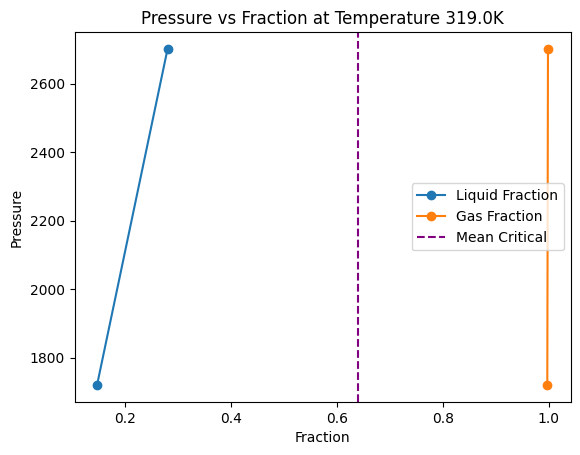

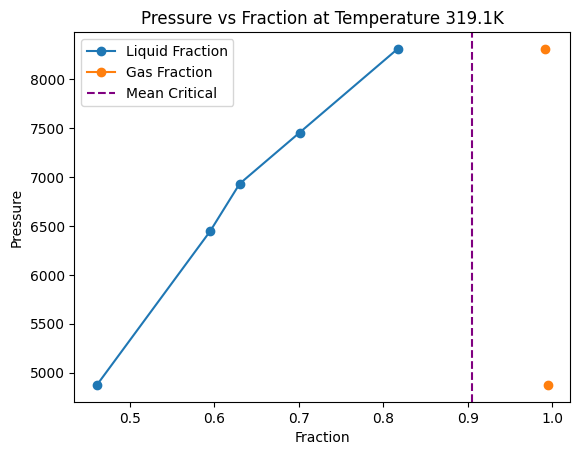

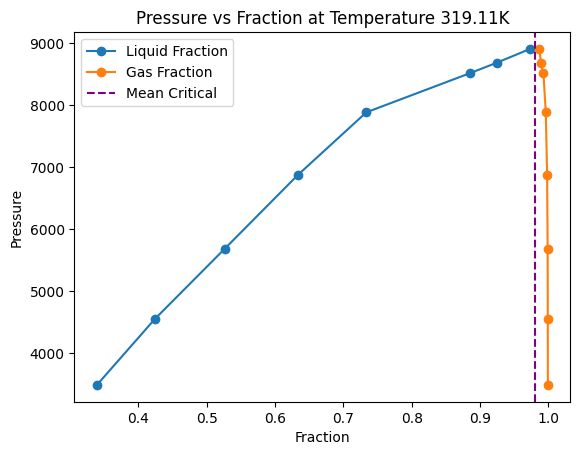

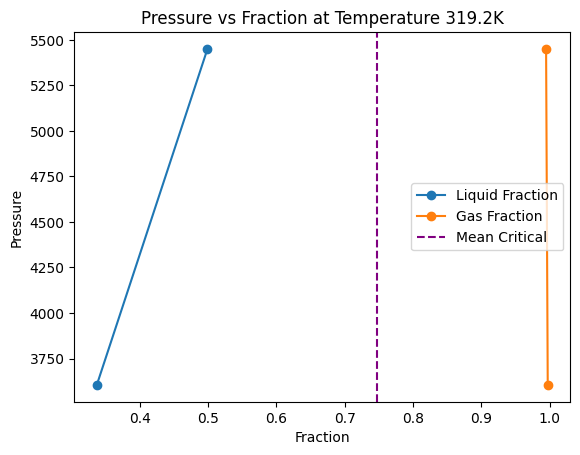

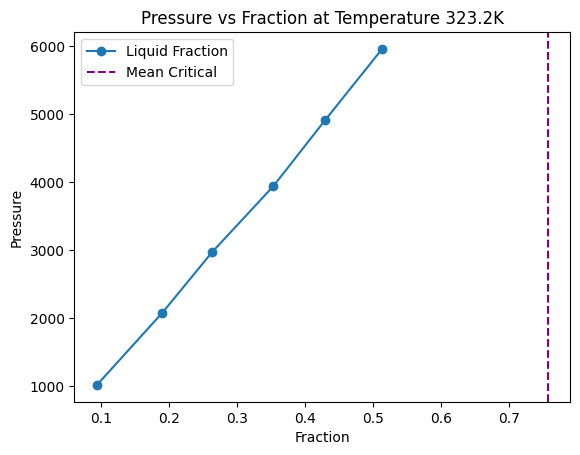

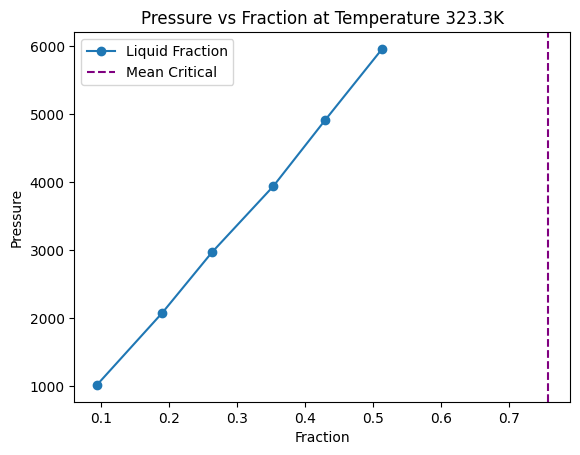

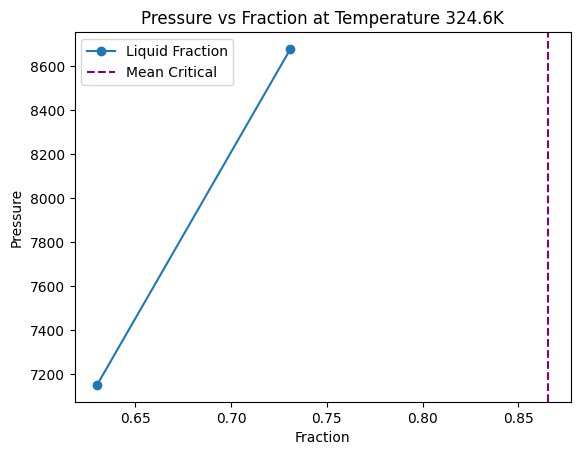

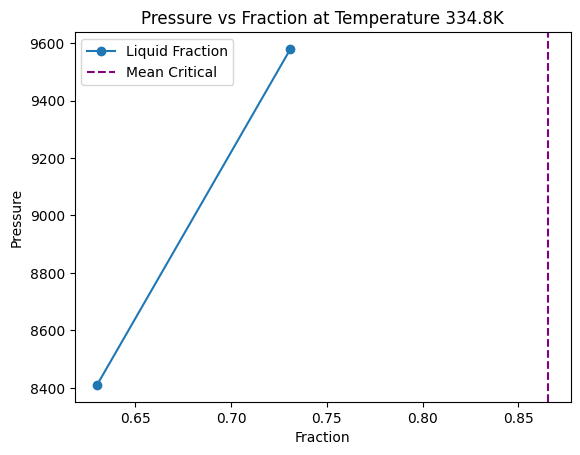

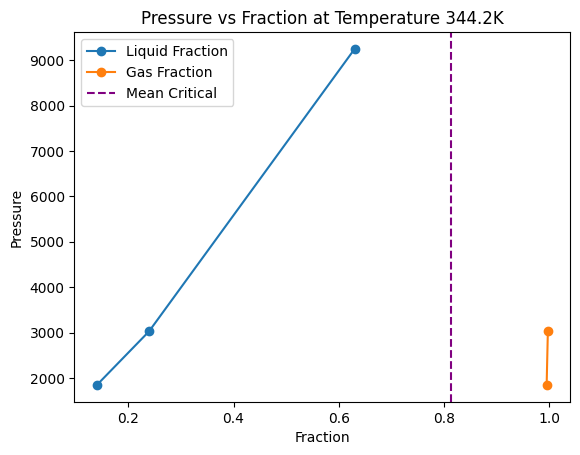

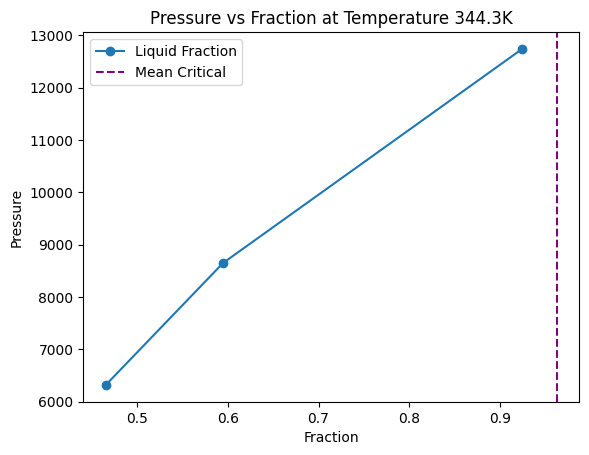

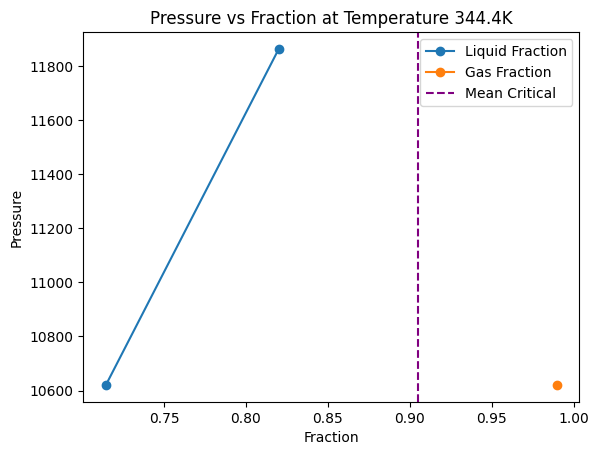

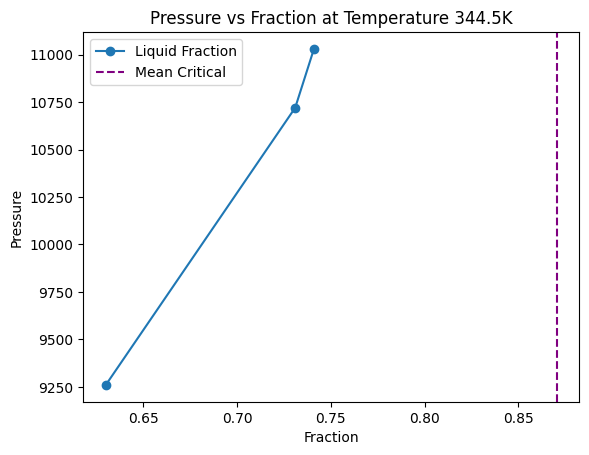

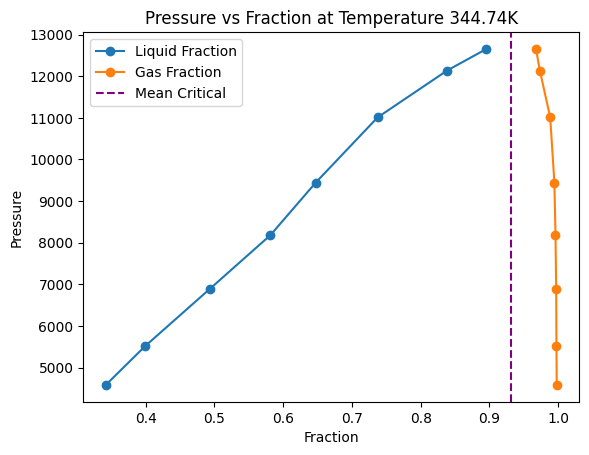

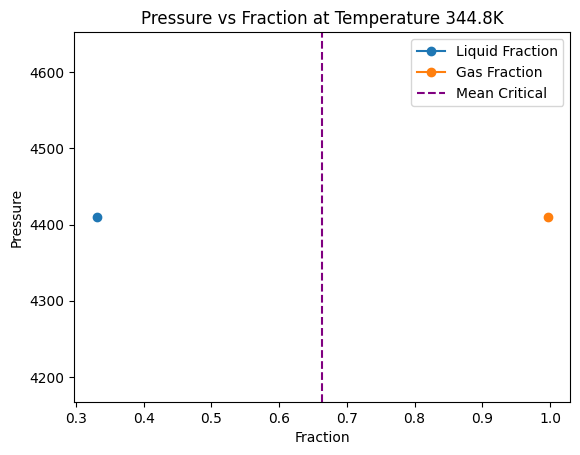

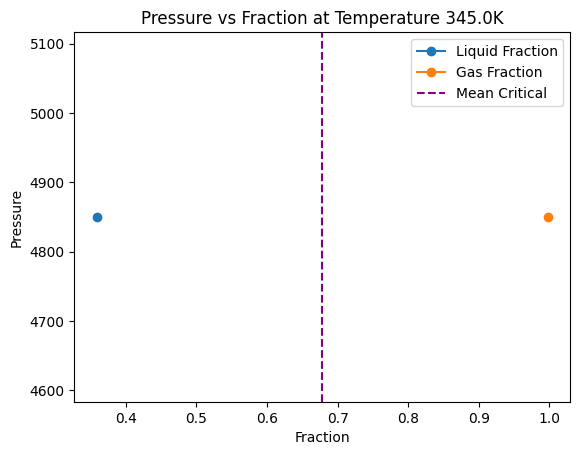

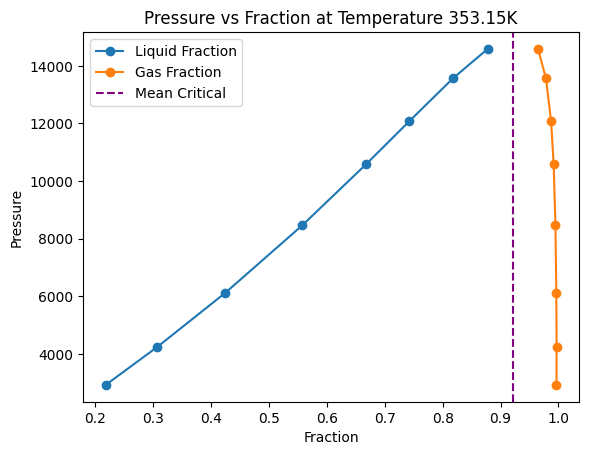

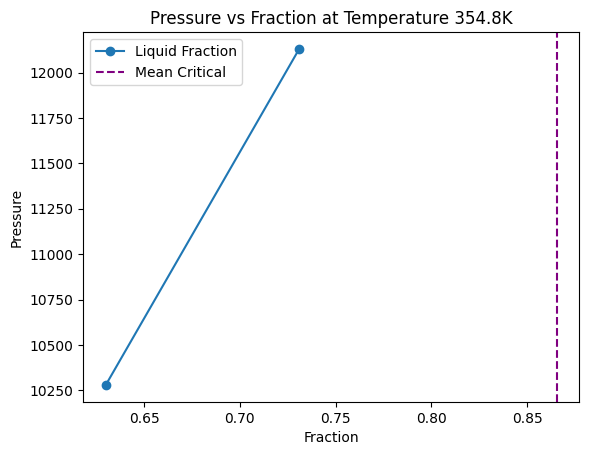

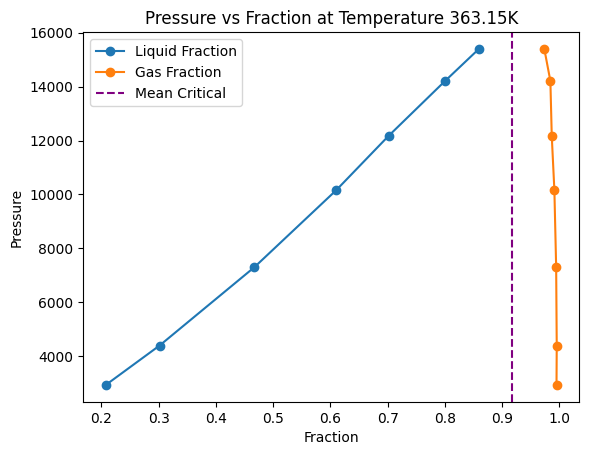

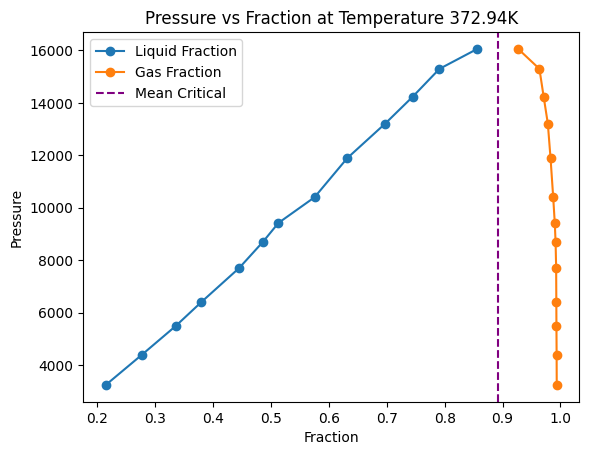

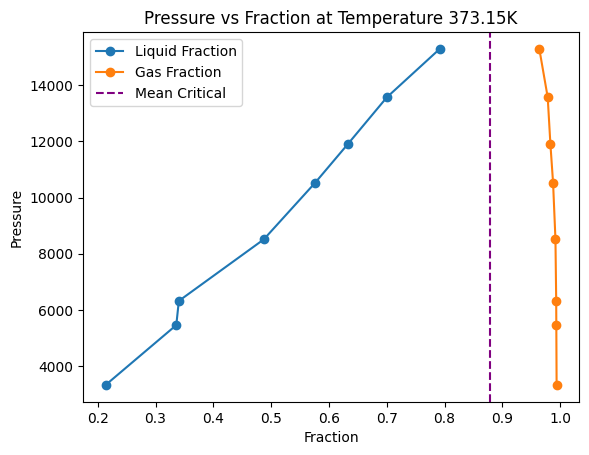

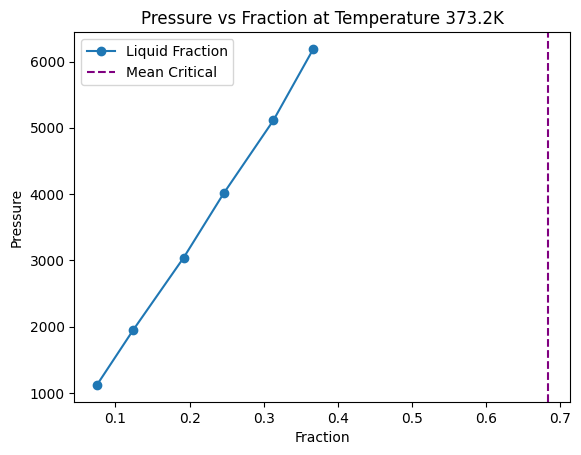

In [8]:
desired_components = ['decane', 'carbon dioxide']
# desired_components = ['dodecane', 'carbon dioxide']
# desired_components = ['propane', 'hydrogen sulfide']
mixture_df = find_permutations(df, desired_components)
filenames = mixture_df['filename'].unique()
if filenames.size > 0:
    refined_df = refine_datasets(mixture_df, filenames)
        
    standart_df = get_standart_df(refined_df)
    # standart_df.head(68)
    
    mean_criticals = get_mean_criticals(standart_df)
    plot_temps(standart_df=standart_df, mean_criticals=mean_criticals)
    
    standart_df['mean_critical'] = standart_df['temperature'].map(mean_criticals)
    standart_df.to_csv(f'{"_".join(desired_components)}_pressure_fraction_graph_data.csv', index=False)
else:
    print(f"No {desired_components} mixture in the dataset!") 

0.07216602665364633 0.020074036837398973


<Figure size 1000x500 with 0 Axes>

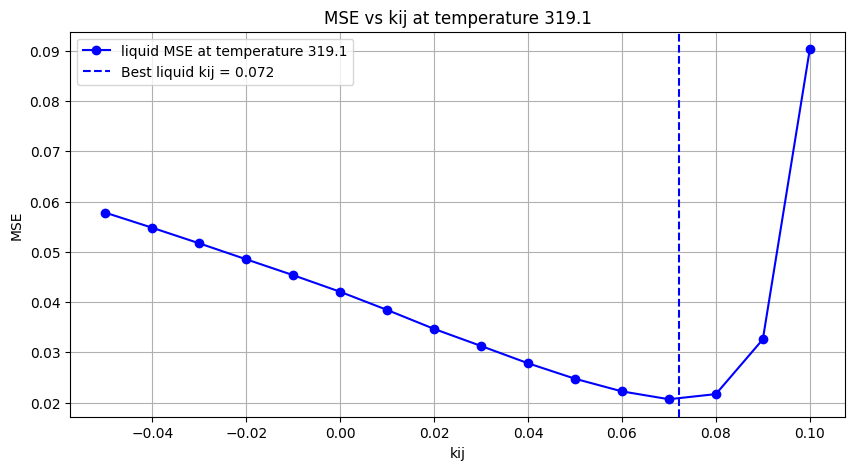

0.07261776513956739 0.014579819550110857


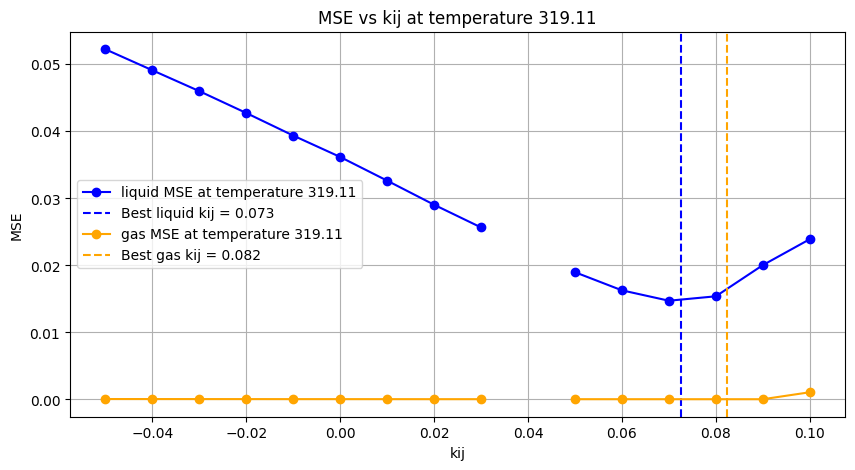

0.0933750046387474 0.00015364502538128474


<Figure size 1000x500 with 0 Axes>

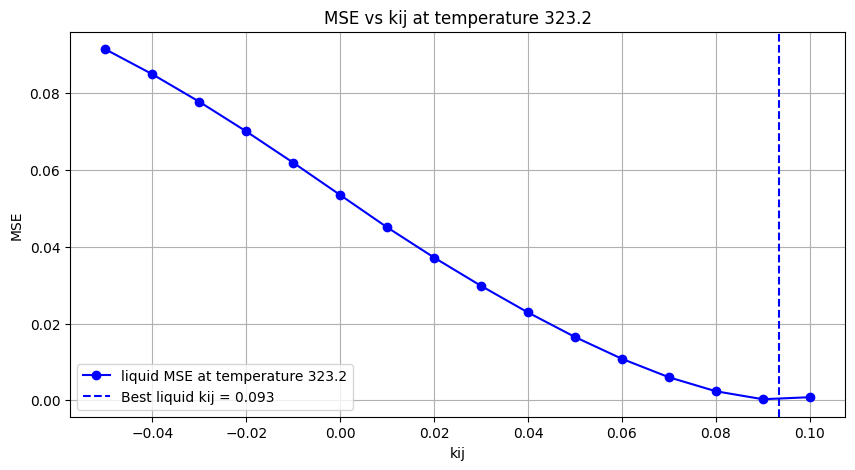

0.09318748847595743 0.00015386736013702634


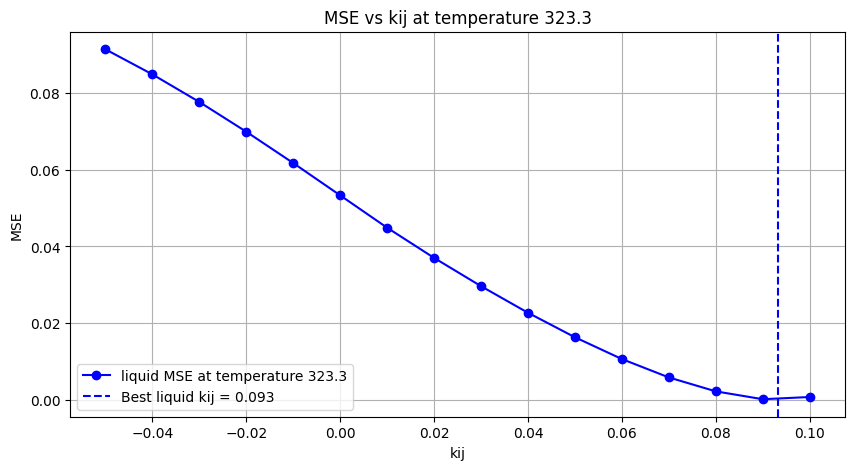

0.08552773614586154 -2.221288712890568e-05


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

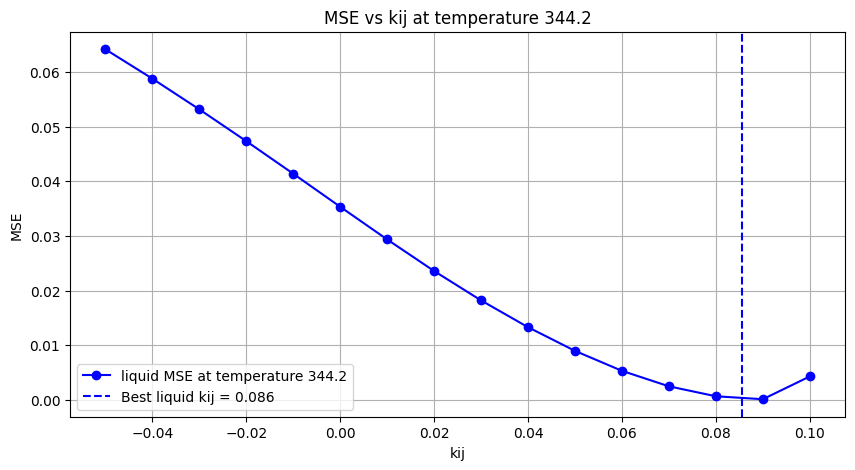

0.06435597195634099 0.01089010271640806


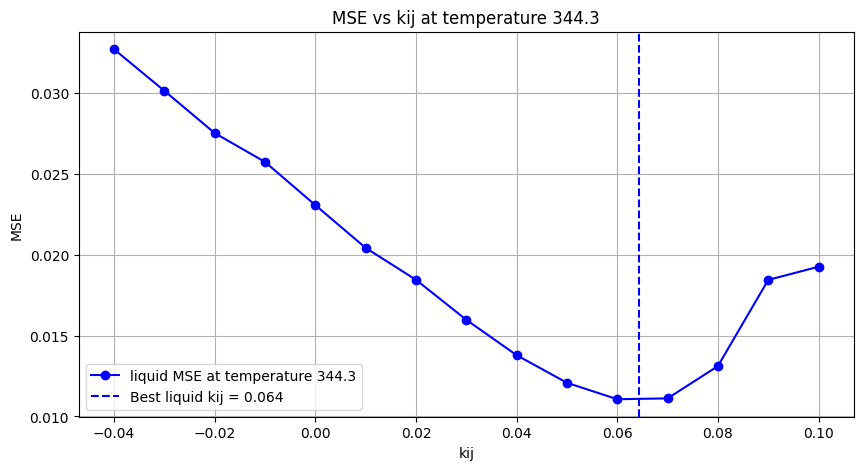

0.09417375116082764 0.5349047311292916


<Figure size 1000x500 with 0 Axes>

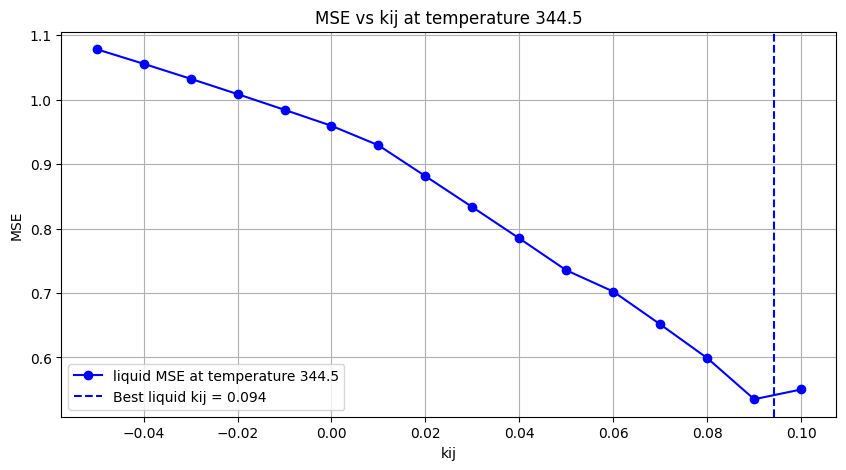

0.06931078960666731 0.003357718080770976


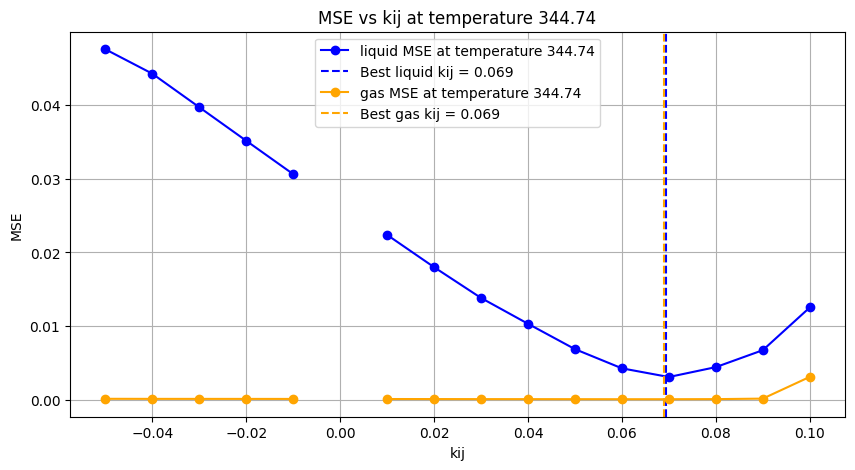

0.07787221776593438 0.0007655058485594585


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

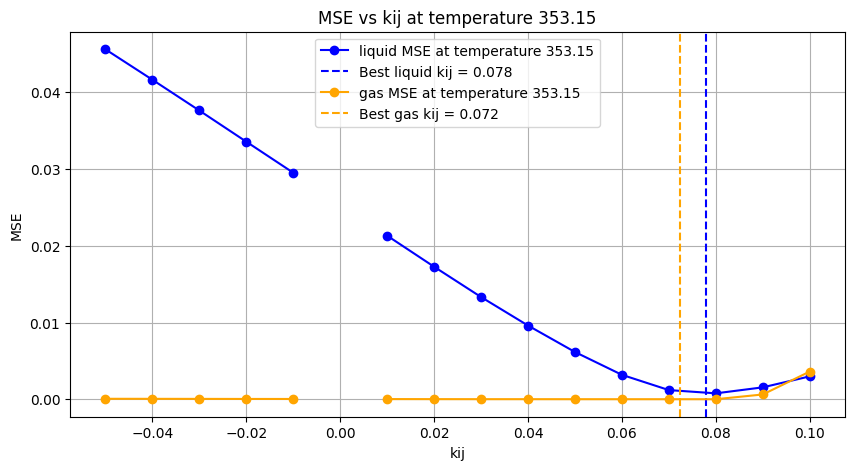

0.07667733525451197 0.0005971665140557872


<Figure size 1000x500 with 0 Axes>

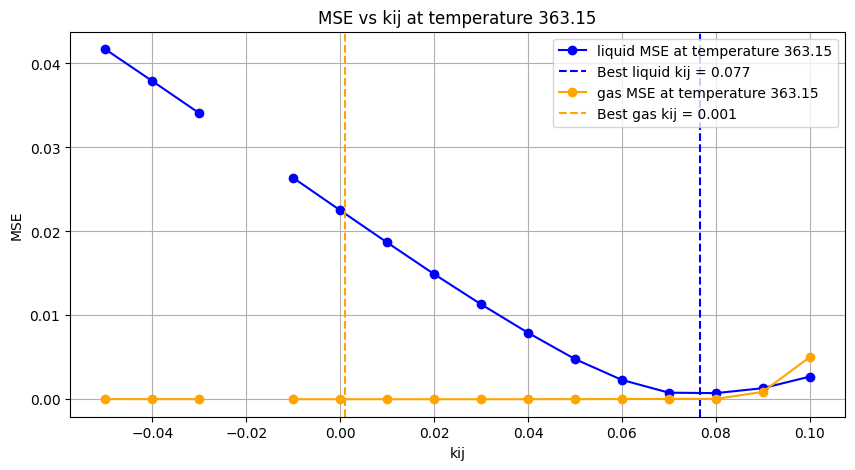

0.07872536939420907 0.0010882235875909543


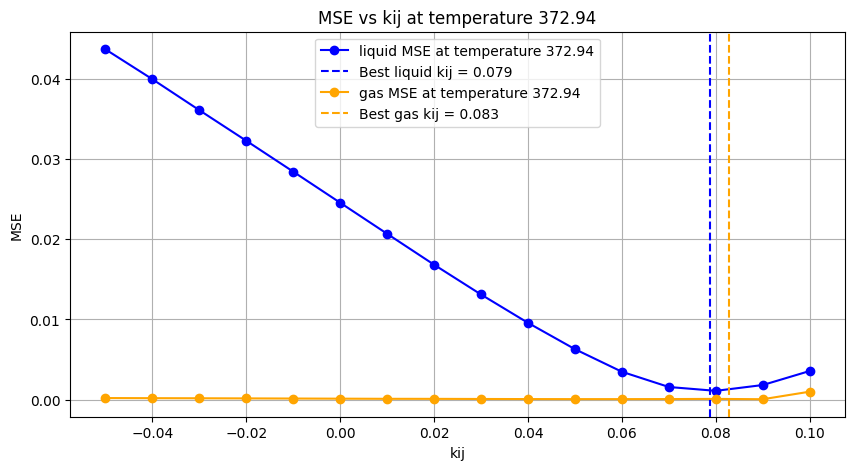

0.0835535644010761 0.0006835558380052648


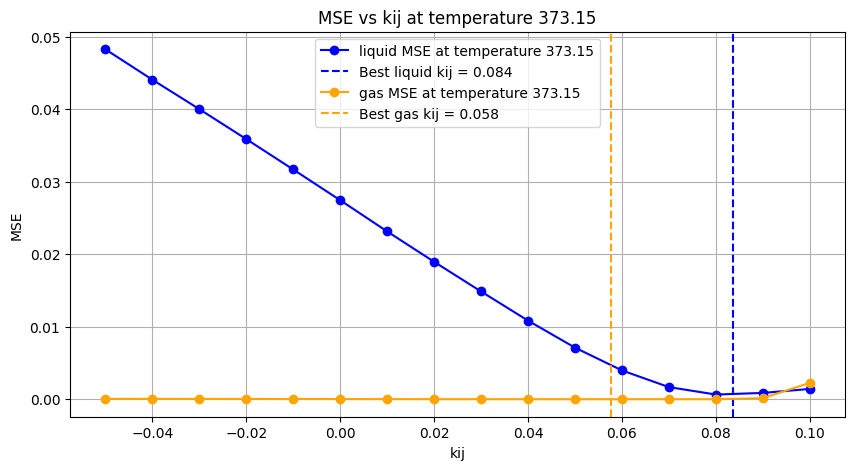

0.08615626150252469 3.742347074019853e-05


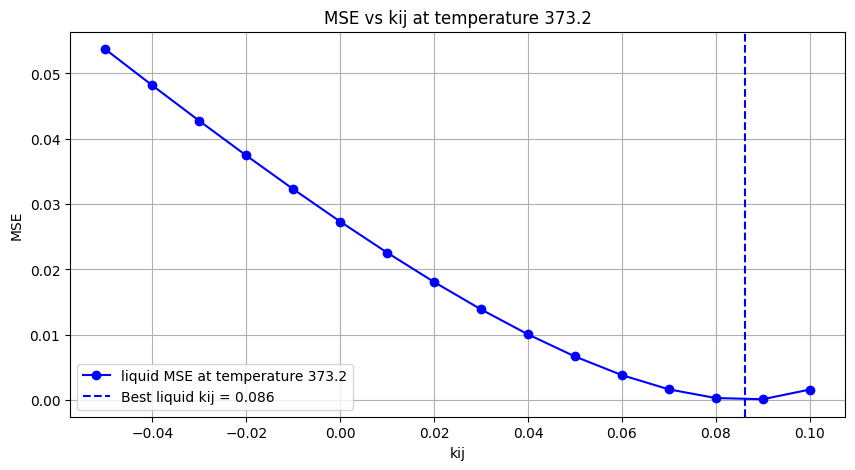

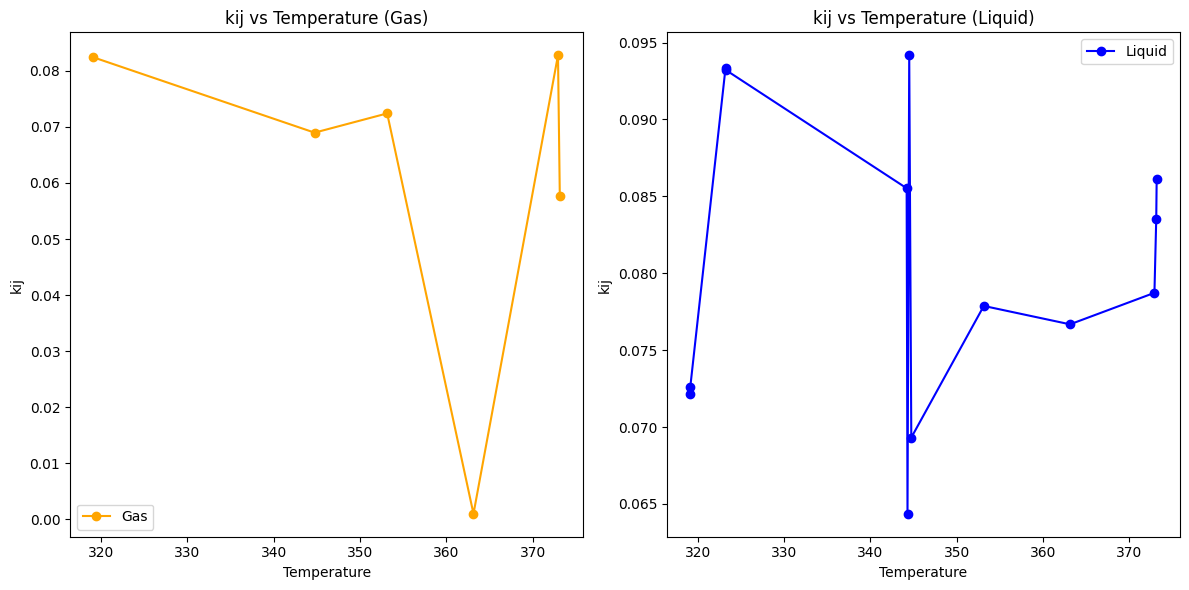

Gas kij mean = 0.06155709711445378
Liquid kij mean = 0.08195336860949899


In [9]:
directory = 'julia_out/sc_data/'
real_data_filename = 'pressure_fraction_graph_data.csv'
mses = calculate_mses(directory, real_data_filename)
plot_mse_t(mses)